# Contents <a id='back'></a>

* [Introduction](#intro)
* [1. Data Overview](#data_review)
    * [Conclusions](#data_review_conclusions)
* [2. Model Training and Evaluation](#model_training_evaluation)
* [3. The Script to Run on the GPU Platform](#script_gpu_platform)
* [4. Output](#output)
* [General Conclusion](#end)

# Introduction <a id='intro'></a>

In this project, I will train and evaluate a model that can predict the age of supermarket customers. This project utilizes the field of computer vision to process photos of the customers. 


**Objective:**

Train the model with a Mean Absolute Error (MAE) value less than 7.

**This project will comprise the following steps:**

1. Data Overview
2. Model Training and Evaluation

[Back to Contents](#back)

## 1. Data Overview <a id='data_review'></a>

The steps to be performed are as follows:
1. Checking the number of rows and columns.
2. Checking for missing values.
3. Checking sample data

[Back to Contents](#back)

In [1]:
# load dataset

import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# load data
df_labels = pd.read_csv('/datasets/faces/labels.csv')

### 1.1 Data Exploration: df_labels

In [3]:
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df_labels.shape

(7591, 2)

In [5]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df_labels.describe

<bound method NDFrame.describe of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

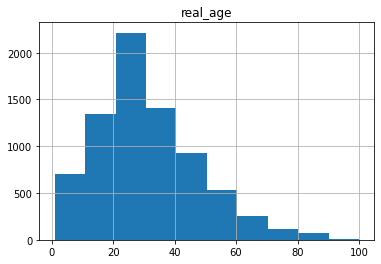

In [7]:
df_labels.hist()

In [8]:
df_labels['real_age'].value_counts().sort_values()

97       1
93       1
91       1
100      1
96       2
      ... 
28     217
26     226
27     229
25     315
30     317
Name: real_age, Length: 97, dtype: int64

<AxesSubplot:>

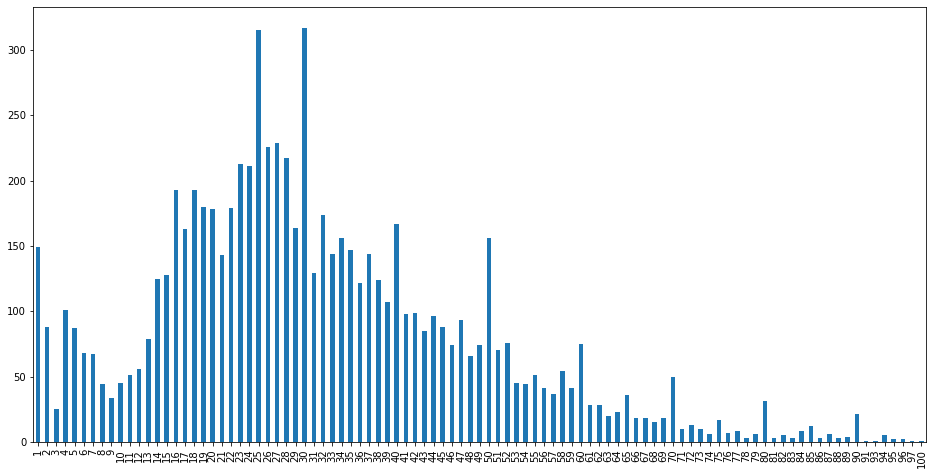

In [10]:
df_labels['real_age'].value_counts().sort_index().plot(kind='bar', stacked=True, figsize=(16, 8))

In [11]:
df_labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

**Data Review Conclusions** <a id='data_review_conclusions'></a>

1. There are no missing values in both columns, "file_name" and "real_age."
2. From the visualization and value_counts of the age distribution above, it can be observed that the age of 30 has the highest count, with 317 data out of a total of 7591 data.
3. The second place is occupied by the age of 25, with a data count of 315.
4. The third place is held by the age of 27, with a data count of 229.
5. The highest concentration of data falls within the age range of 23 - 30.

### 1.2 Samples in the Dataset

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


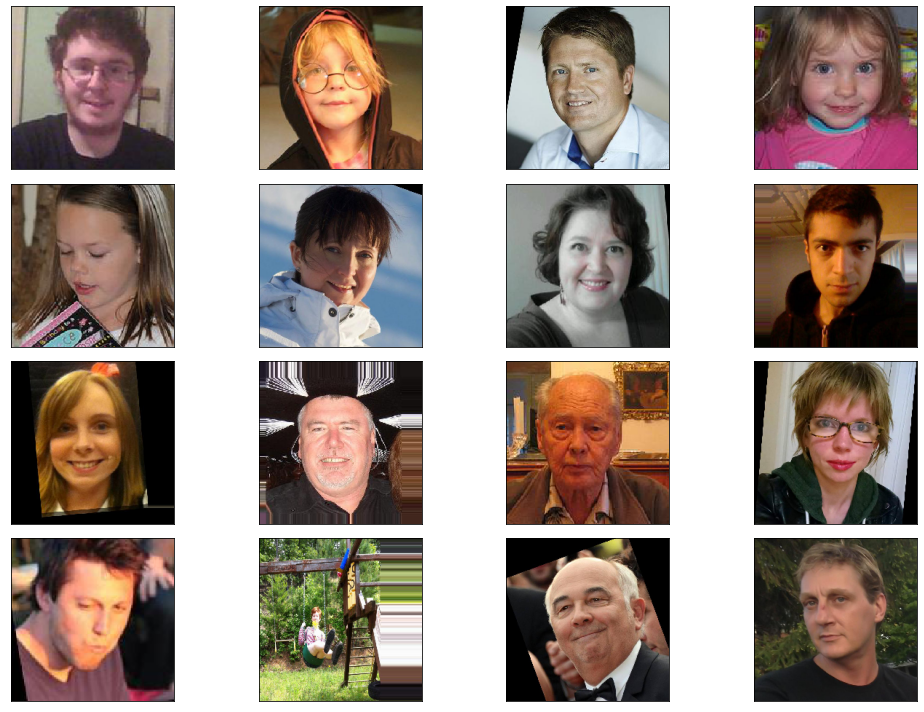

In [17]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(16,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Findings**

1. Some photos appear too distant, some individuals are not looking towards the camera, and there are also those wearing glasses.
2. This could pose challenges regarding the accuracy of the model in predicting the actual age.

[Back to Contents](#back)

## 2. Model Training and Evaluation <a id='model_training_evaluation'></a>

In [18]:
def load_train(path):
    df_labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

In [19]:
def load_test(path):
    
    df_labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [20]:
def create_model(input_shape):
 
    backbone = ResNet50(
                input_shape=input_shape,
                weights='imagenet', 
                include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [21]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

[Back to Contents](#back)

## 3. The Script to Run on the GPU Platform <a id='script_gpu_platform'></a>

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## 3. Output <a id='output'></a>

Train for 356 steps, validate for 119 steps

Epoch 1/5
2023-07-30 09:46:41.435602: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-30 09:46:41.663094: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 46s - loss: 204.4142 - mae: 10.3415 - val_loss: 650.7673 - val_mae: 20.5024

Epoch 2/5
356/356 - 38s - loss: 82.4307 - mae: 6.8452 - val_loss: 131.1836 - val_mae: 8.5797

Epoch 3/5
356/356 - 38s - loss: 55.5874 - mae: 5.7041 - val_loss: 74.7165 - val_mae: 6.4103

Epoch 4/5
356/356 - 38s - loss: 44.0171 - mae: 5.0781 - val_loss: 82.7484 - val_mae: 6.7459

Epoch 5/5
356/356 - 37s - loss: 35.9987 - mae: 4.5276 - val_loss: 74.0009 - val_mae: 6.5587

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 74.0009 - mae: 6.5587

Test MAE: 6.5587

[Back to Contents](#back)

# General Conclusions <a id='end'></a>

Based on a research paper (link: https://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), a model is considered good if it has an MAE of less than 7.

According to the output above, the MAE value is 6.5. Therefore, it can be concluded that the trained model has the ability to predict the age of customers with a high level of accuracy.

The trained model has the ability to predict the age of customers with a high level of accuracy. Achieving a Mean Absolute Error (MAE) value of 6 is a good indicator, as for user categories, an inaccuracy of 6 years is not overly concerning. This is particularly true because the customer categories are divided with an age difference of around 8-12 years.

The use of GPU and neural networks enables the processing of large amounts of information quickly and efficiently, while also providing a high level of accuracy.

[Back to Contents](#back)